In [149]:
import numpy as np
import cv2
import matplotlib.image as im
import matplotlib.pyplot as plt

In [150]:
class DataLoader:
    def load(self,dir_path):
        folders = os.listdir(dir_path)
        labels = []
        features = []
        for label_name in folders:
            files = os.listdir(label_name)
            for img_path in files:
                img = im.imread(img_path)
                img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                feature,hog_img = hog(img_gray,
                                    orientations=11,
                                    pixels_per_cell=(16, 16),
                                    cells_per_block=(2, 2),
                                    visualize=True,
                                    transform_sqrt=False,
                                    feature_vector=True)
                features.append(feature)
                labels.append(label_name)
        return np.asarray(features),np.array(labels)


class ObjectIdentifier:
    def __init__(self,MIN_CONF=0.5):
        self.net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
        self.net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        self.MIN_CONF = MIN_CONF

    def predict(self,img):
        ln = self.net.getLayerNames()
        ln = [ln[i - 1] for i in self.net.getUnconnectedOutLayers()]

        # construct a blob from the image
        blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
        
        r = blob[0, 0, :, :]
        
        self.net.setInput(blob)
        outputs = self.net.forward(ln)
        
        return self.identify(img,outputs)
        
    def identify(self,img, outputs):
        boxes = []
        confidences = []
        classIDs = []

        IMG_WIDTH = img.shape[1]
        IMG_HEIGHT = img.shape[0]

        for output in outputs:
            for detection in output:
               
                #Getting scores
                scores = detection[5:]

                #Finding max score
                class_id = np.argmax(scores)

                #Getting the corresponding confidencce
                confidence = scores[class_id]

                #Create box if the confidence is greater than min conf
                if confidence > self.MIN_CONF:
                    #Calculating box params
                    center_x = int(detection[0] * IMG_WIDTH)
                    center_y = int(detection[1] * IMG_HEIGHT)

                    w = int(detection[2] * IMG_WIDTH)
                    h = int(detection[3] * IMG_WIDTH)

                    x = center_x - w / 2
                    y = center_y - h / 2

                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])
                    
        return boxes,confidences,classIDs
                
    def draw_box(self,boxes,confidences):
        indices = cv.dnn.NMSBoxes(boxes, confidences, conf, conf-0.1)
        if len(indices) > 0:
            for i in indices.flatten():
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                color = [int(c) for c in colors[classIDs[i]]]
                cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
                cv.putText(img, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

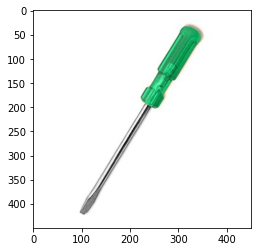

In [151]:
objIdentifier = ObjectIdentifier(MIN_CONF=0.5)

img = im.imread("screw_driver.jpg")
plt.imshow(img)

In [152]:
outputs = objIdentifier.predict(img)
outputs

([], [], [])